<a href="https://colab.research.google.com/github/drwbkr1/Grad504-K-Nearest-Neighbor-Classifier/blob/main/KNN_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import time
import warnings
from collections import Counter

In [152]:
#Any dataset is verified for basic parameters before preprocessing.
def load_csv(file):
  df= pd.read_csv(file)

  #Check for data in dataset, numerical features for supporting floating-point inputs
  if df.shape[1] < 2:
    raise ValueError("File must have at least one feature and a target")
  try:
    X_df= df.iloc[:, :-1].astype(float)
  except ValueError:
    warnings.warn("WARNING: Non-numerical datapoints (missing values or categorical) detected!")

  #Split dataset into features and target, features to floating point.
  X= df.iloc[:, :-1].to_numpy()
  y= df.iloc[:, -1].to_numpy()

  #Check for feature-target congruency, feature congruency
  if not X.shape[0]==y.shape[0]:
    raise ValueError("Error: Features and target must have the same length")
  if not all(len(features)==len(X[0]) for features in X):
    raise ValueError("Error: All features must have the same length")

  return X, y

In [161]:
#Establish the model class to create new instance for any dataset. Includes classifier mechanics and fit/predict methods
class KNNClassifier:
  def __init__(self, n_neighbors): #Creates an instance of the KNNClassifier
    self.k= n_neighbors
    self.X_train= []
    self.y_train= []

  def fit(self, X_train, y_train): #Receives training split, fit it to KNN instance
    self.X_train= X_train
    self.y_train= y_train

  def euclidean_distance(self, X_test, X_train): #Standard distance formula
    distance= np.sqrt(sum((X_testi - X_traini)**2 for X_testi, X_traini in zip(X_test, X_train)))
    return distance

  def KNN_classifier(self, X_test): #Gathers all distances from a test point, orders them by size, selects closest train points, assigns most common class
    distances= [(self.euclidean_distance(X_test, X_train), label) for X_train, label in zip(self.X_train, self.y_train)]
    distances.sort(key=lambda x: x[0])
    k_neighbors= [label for _, label in distances[:self.k]]
    return Counter(k_neighbors).most_common(1)[0][0]

  def predict(self, X_test): #Utilizes KNN_classifier method to create a list of predicted classifiers
    return [self.KNN_classifier(x) for x in X_test] #This is where the model loops over each row in the test set

In [154]:
def train_test_split(X, y, train_frac= .1): #randomizes index, splits index at percentage, assigns split indexes to train and test arrays
  rng= np.random.default_rng(seed= 0)
  shuffled_idx= rng.permutation(len(X))
  n_train= int(len(X) * train_frac)

  train_idx= shuffled_idx[:n_train]
  test_idx= shuffled_idx[n_train:]

  X_train= X[train_idx]
  y_train= y[train_idx]
  X_test=X[test_idx]
  y_test= y[test_idx]
  return X_train, y_train, X_test, y_test

In [155]:
def KNN_fit_pred(k= 5): #assigns model instance, fits training data, predicts on test data
  model= KNNClassifier(n_neighbors= k)
  model.fit(X_train, y_train)
  predictions= model.predict(X_test)
  return predictions

In [159]:
#The list of datasets used during the project
course= ("/content/drive/MyDrive/Colab Notebooks/datasets/Prog1data.csv") #The required dataset
iris= ("/content/drive/MyDrive/Colab Notebooks/datasets/Iris.csv") #dataset w/ float points and multiple classes
autos= ("/content/drive/MyDrive/Colab Notebooks/datasets/auto-mpg.csv") #dataset to trigger missing data error handling

#Just copy/paste the desired variable into the load_csv parameter
X, y= load_csv(course)
for i in range(3):
  print(X[i], y[i])
print(X.dtype, y.dtype)

[ 8  9  0 26 10 25  7 68  2  7 10] +
[ 8  8  0 23  9 15  5 70  3  7 10] +
[11  3  6 19  8 17  6 80  2  6 10] +
int64 object


Accuracy: 0.983


<Axes: xlabel='Predicted', ylabel='Actual'>

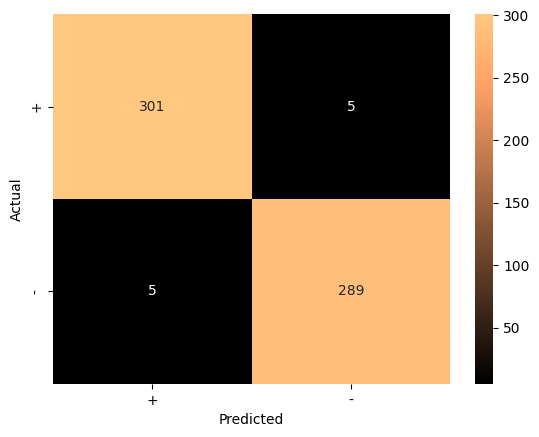

In [160]:
#The primary codeblock for testing/validating predictions
X_train, y_train, X_test, y_test= train_test_split(X,
                                                   y,
                                                   train_frac= .7) #Adjust train/test split here

predictions= KNN_fit_pred(k=5) #Adjust k here
correct= sum(p==a for p, a in zip(predictions, y_test))
total= len(y_test)
accuracy= correct/total

print(f'Accuracy:{accuracy: .3f}')

#Let's see what the predictions look like in a Confusion Matrix
cm = pd.crosstab(y_test,
                 predictions,
                 rownames=['Actual'],
                 colnames=['Predicted'])

sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="copper")

In [76]:
#A very rudimentary test to see how the model handles tie breakers
tie_train_X= [[1,1], [1,1]], [[1,1], [1,1]], [[1,1], [1,1]], [[1,1], [1,0]]
tie_train_y=   [['+','-'],     ['A', 'B'],     ['B', 'A'],     ['B', 'A']]

tie_test_X= [[0,0]]

for X, y in zip(tie_train_X, tie_train_y):
  X_train= X
  y_train= y
  X_test= tie_test_X

  tie_predictions= KNN_fit_pred(k=2) #k as 2 forces it to choose one of the two training points
  print(tie_predictions)


['+']
['A']
['B']
['A']


In [17]:
#Codeblock for compiling performance metrics (data size, compute time)
step_sizes= [100, 200, 300, 500, 600, 700, 1000, 1500, (len(X) - 1)]
rows= []
memories= []
times= []

for n_rows in step_sizes: #Testing the model on samples of the dataset that match the step sizes above
  if n_rows > len(X): #mainly if testing smaller datasets than the step sizes listed (Iris)
    break

  X_subset= X[:n_rows] #Looping with these subsets (Eg X_subset= X[1:100]...X[1:1500]...)
  y_subset= y[:n_rows]
  size= X_subset.nbytes + y_subset.nbytes #This is where it collects the byte size of the subsets

  X_train, y_train, X_test, y_test= train_test_split(X_subset,
                                                     y_subset,
                                                     train_frac= .8)

  n_repeats= 3 #for timing, test each subset n times and get an average
  total_elapsed= 0.000
  for _ in range(n_repeats):
    t0= time.time()
    KNN_fit_pred()
    t1= time.time()
    total_elapsed += (t1 - t0) #the n iterations add to total_elapsed from above

  avg_time= (total_elapsed / n_repeats) #the mean time

  rows.append(n_rows) #for each loop through the sample sizes,
  memories.append(size) #the metrics are added to their respective lists at the top
  times.append(avg_time)

data= [rows, memories, times]
table= pd.DataFrame(data).T #.T transposes the data list to make it legible in a dataframe table
table.columns= ['Rows', 'Memory (bytes)', 'Time (sec)']
table

,Rows,Memory (bytes),Time (sec)
0,100.0,9600.0,0.017301
1,200.0,19200.0,0.074095
2,300.0,28800.0,0.132072
3,500.0,48000.0,0.380693
4,600.0,57600.0,0.534283
5,700.0,67200.0,0.925015
6,1000.0,96000.0,2.145096
7,1500.0,144000.0,4.214377
8,1998.0,191808.0,6.845496
